# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
###  1. Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline


In [2]:
# try create new directory if not exist
def create_dir(path):
    try:  
        os.mkdir(path)
    except:
        pass
    
# show images given path of images    
def showImgs(imgs_path, Nc=2, size=(20, 20), cmap="viridis"):
    filenames = os.listdir(imgs_path)
    length = len(filenames)
    Nr = int((length - 1) / Nc) + 1
    figure, axs = plt.subplots(Nr, Nc, figsize=size)  
    for row in range(Nr):
        for col in range(Nc):
            index = row * Nc + col
            if index >= length:
                break 
            img = mpimg.imread(imgs_path + filenames[index]) 
            #print(img.shape)
            title = filenames[index].split('.')[0]
            axs[row, col].title.set_text(title)
            #print("s", img.shape)
            axs[row, col].imshow(img, cmap=cmap)
    

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# create a directory to store output
corner_path = './output_images/camera_cal_corners/'
create_dir(corner_path)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for img_path in images:
    img = mpimg.imread(img_path)
    img_name =  os.path.basename(img_path)  # get image name
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        # plt.title(img_name)
        # plt.imshow(img)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imsave(corner_path + img_name, img)       
       
#showImgs(corner_path, Nc=6, size=(20, 10))

###  2. Distortion correction

#### Camera calibrition undistortion

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

camera_undist_path = './output_images/camera_cal_undist/'
create_dir(camera_undist_path)

for img_path in images:
    img = mpimg.imread(img_path)
    img_name =  os.path.basename(img_path) 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    plt.imsave(camera_undist_path + img_name, undistorted)
    
    
#showImgs(camera_undist_path, Nc=6, size=(20, 10))  # uncomment to display undistorted images

#### Test images undistortion 

h =  720 
w =  1280


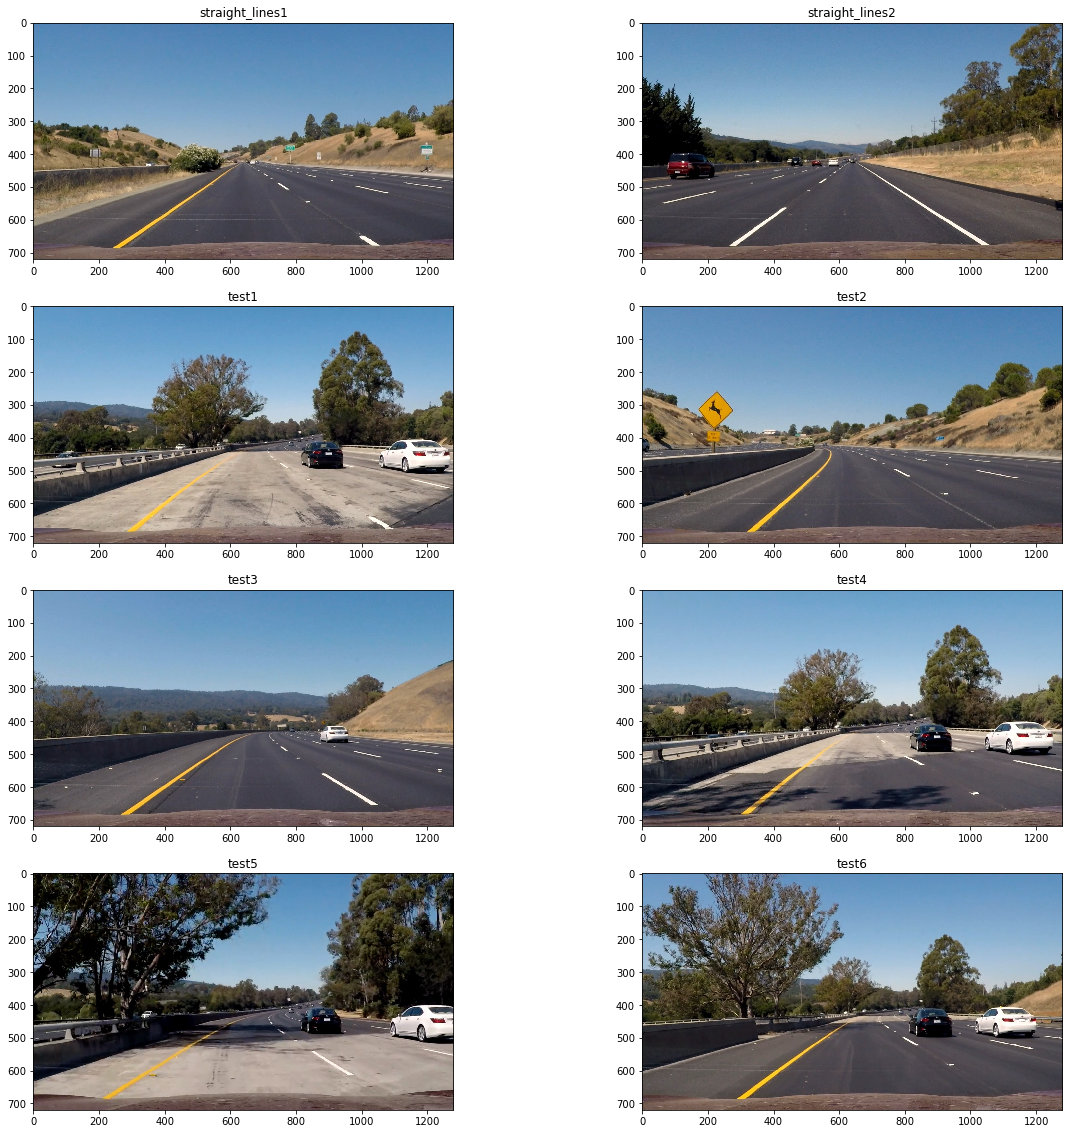

In [5]:
test_imgs_path = "./test_images/"
test_imgs_names = os.listdir(test_imgs_path)

# get the shape of img, h, w will be used later
sample = mpimg.imread(test_imgs_path + test_imgs_names[0])
h = sample.shape[0]
w = sample.shape[1]
print("h = ", h, "\nw = ", w)

showImgs(test_imgs_path)

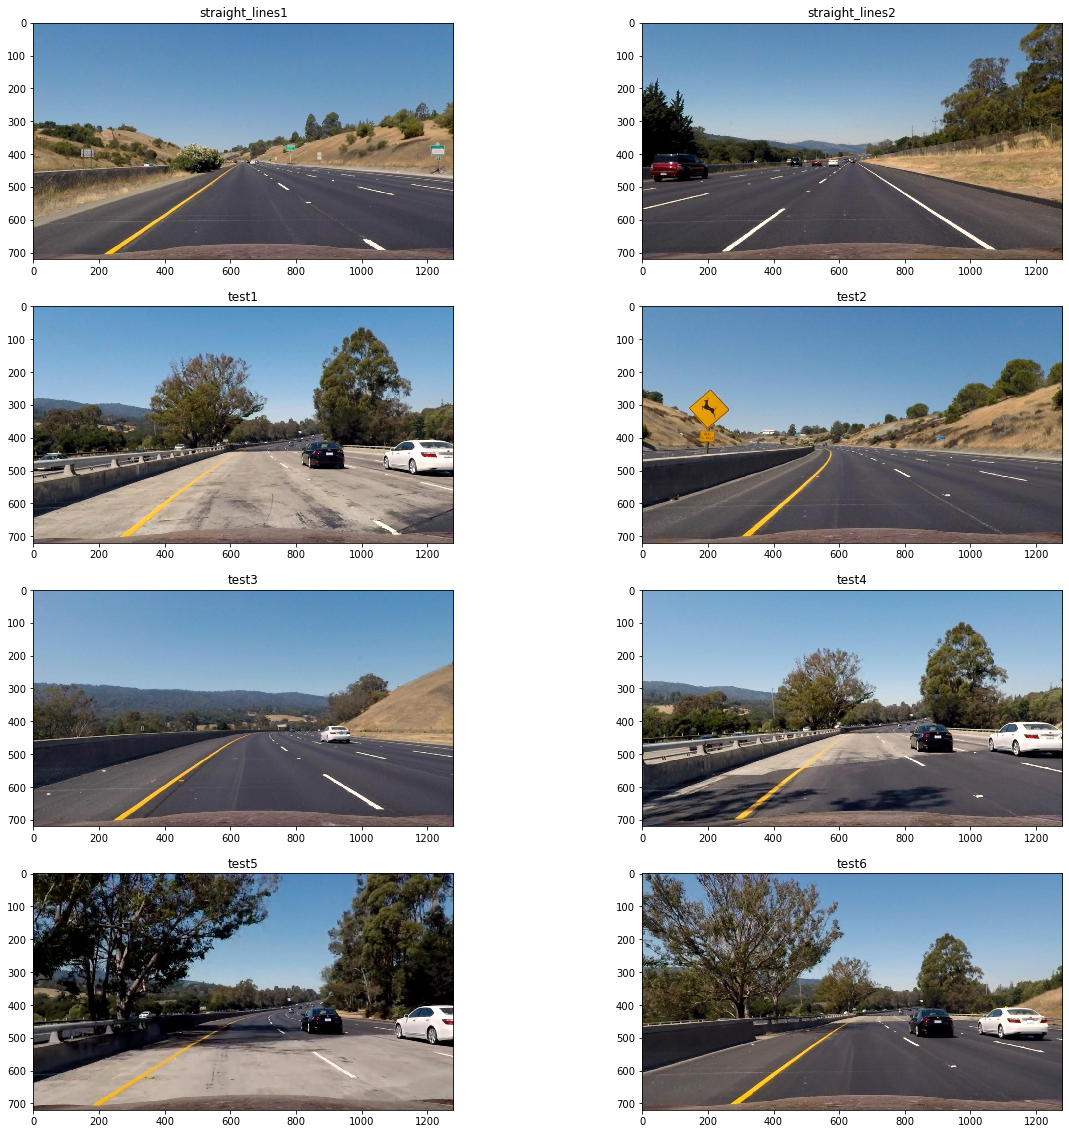

In [6]:
# create a directory to store output
undistort_path = './output_images/undistort/'
create_dir(undistort_path)


for img_name in test_imgs_names:
    img = mpimg.imread(test_imgs_path + img_name)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    plt.imsave(undistort_path + img_name, undistorted)

    
showImgs(undistort_path)

### 3. Color/gradient threshold

In [7]:
# apply a function to images in path and save the result
def apply(pipline, origin_path, save_path, cmap='viridis'): 
    """
    apply sequential functions in pipline to image 
    pipline: list of functions 
    """
    img_names = os.listdir(origin_path)
    for img_name in img_names:
        img = mpimg.imread(origin_path + img_name)
        for func in pipline:
            img = func(img)
        #print(img.shape)
        mpimg.imsave(save_path + img_name, img, cmap=cmap)

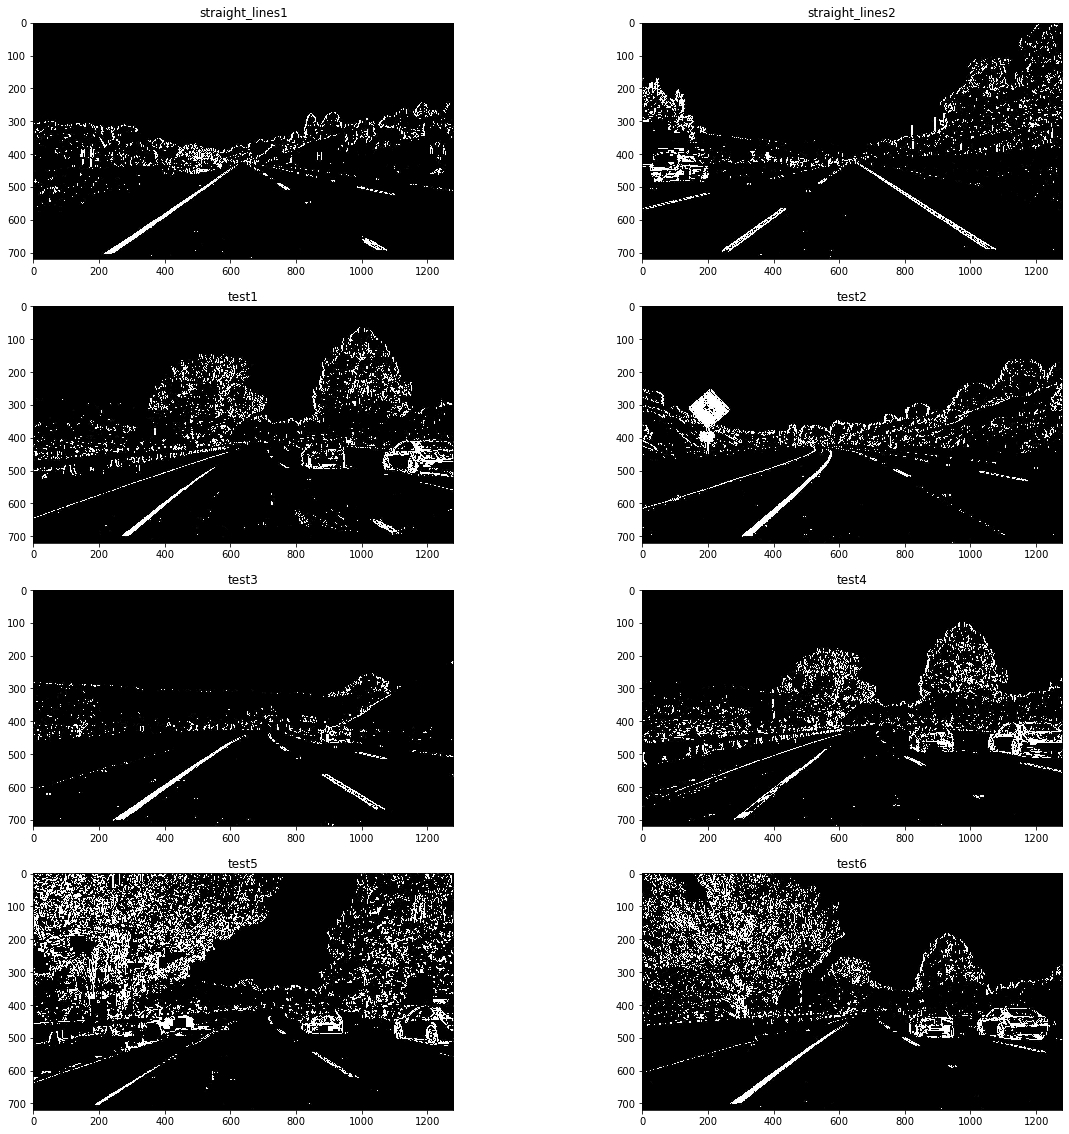

In [8]:
# use color gradient etc threshold to get a binary image
def binary_combo(img, s_thresh=(200, 255), sx_thresh=(30, 255)):  # 100, 5
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=5) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1



    return combined_binary


binary_combo_path = "./output_images/binary_combo/"
create_dir(binary_combo_path)
apply([binary_combo], undistort_path, binary_combo_path, cmap='gray')
showImgs(binary_combo_path)

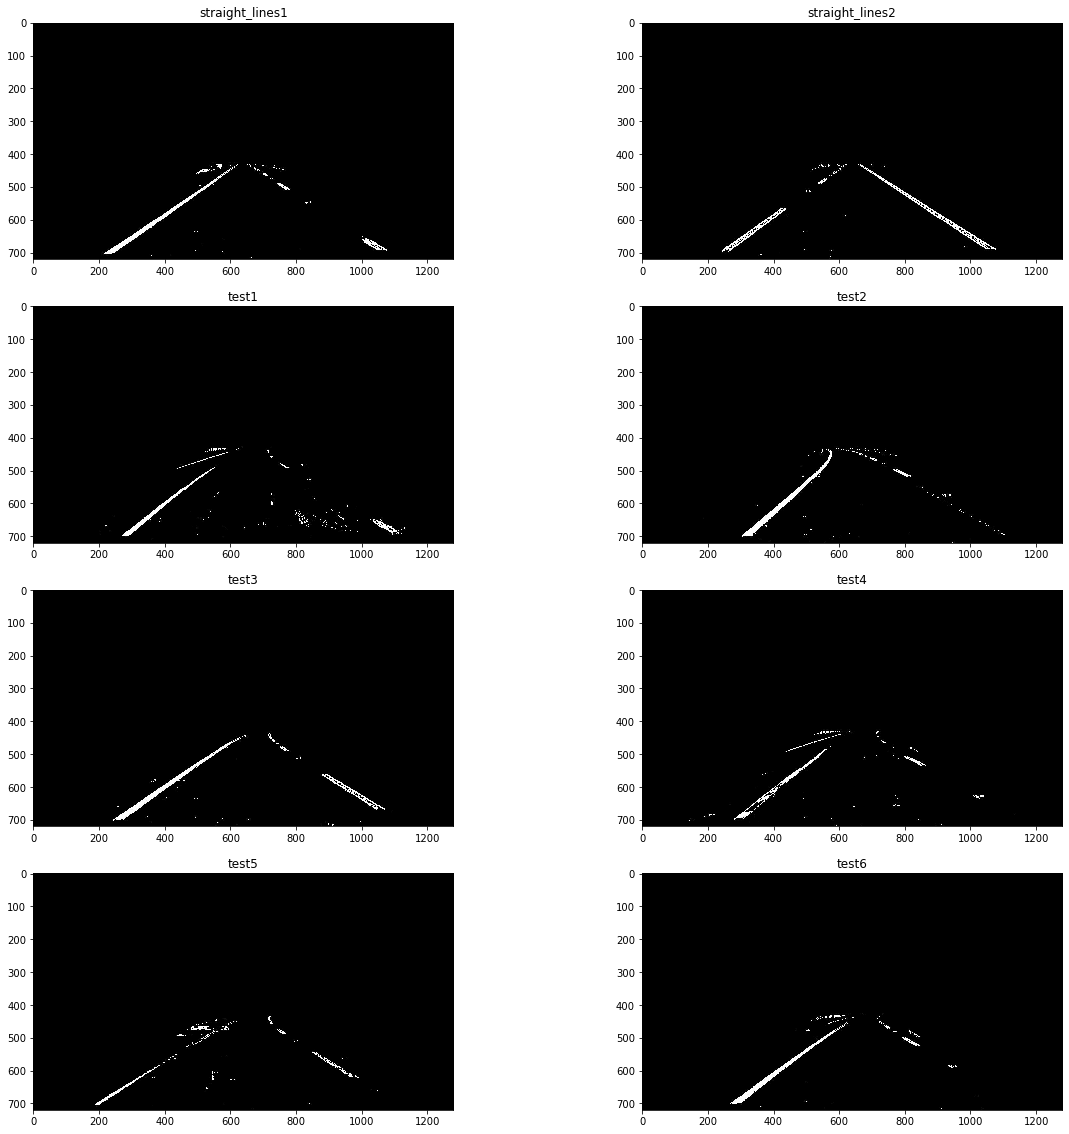

In [9]:
# define region of interest
# upper and lowr boundary of y(notice y = 0 at the top of image, y = h - 1 at the bottom of image)
lower_y = int(0.6 * h) - 1  
upper_y = h - 1
vertices = np.array([[(0.05 * w - 1, h - 1), (0.425 * w - 1, lower_y), 
                      (0.575 * w - 1, lower_y), (0.95 * w - 1, upper_y)]],
                       dtype = np.int32)  
def apply_mask(img, vertices=vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    # Create a masked img
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


masked_path = "./output_images/masked/"
create_dir(masked_path)
apply([binary_combo, apply_mask], undistort_path, masked_path, cmap='gray')
showImgs(masked_path)

### 4. Perspective transform

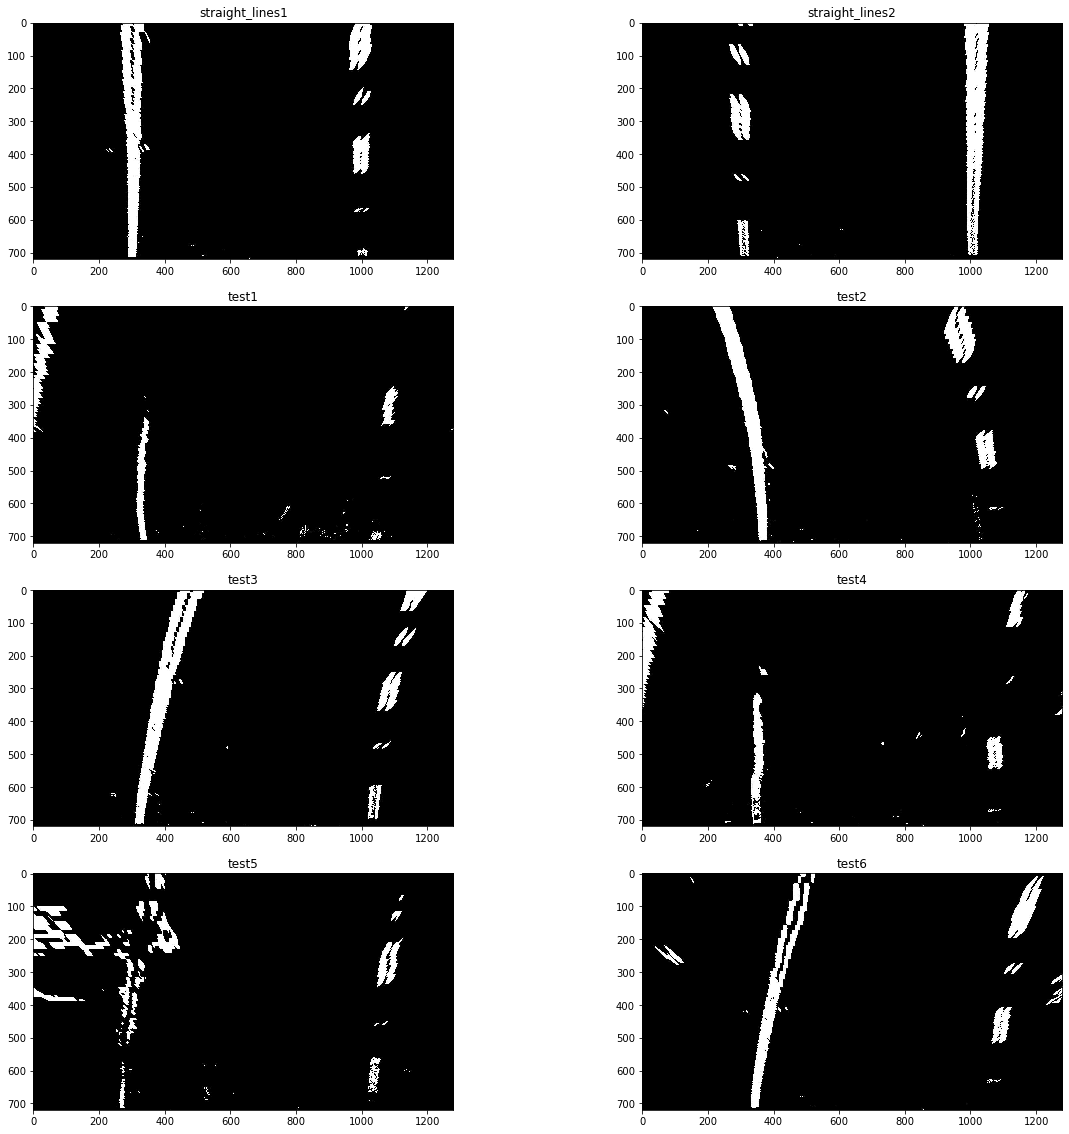

In [10]:
src = np.float32([[585, 460],
                 [230, 720],
                 [1050, 720],
                 [695, 460]])
dst = np.float32([[320, 0], 
                  [320, 720],
                  [960, 720],
                  [960, 0]])

def warp(img, src=src, dst=dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped


warped_path = "./output_images/warped/"
create_dir(warped_path)
apply([binary_combo, apply_mask, warp], undistort_path, warped_path, cmap='gray')
showImgs(warped_path)



# def warp(img):
#     h = img.shape[0]
#     w = img.shape[1]
#     lower_y = int(0.65 * h) - 1
#     upper_y = h - 1
#     # Define a four sided polygon to mask
#     vertices = np.array([(0.05 * w - 1, h - 1), (0.425 * w - 1, lower_y), 
#                           (0.575 * w - 1, lower_y), (0.95 * w - 1, upper_y)],
#                        dtype = np.int32)
#     src = np.float32([vertices[0], vertices[1], vertices[2], vertices[3]])
#     alpha = 0.3
#     dst = np.float32([(alpha * w - 1, h - 1), (alpha * w - 1, 0), 
#                       ((1 - alpha) * w - 1, 0), ((1 - alpha) * w - 1, h - 1)],
#                     dtype=np.int32)        
#     M = cv2.getPerspectiveTransform(src, dst)
#     warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
#     return warped



### 5. Detect lane lines

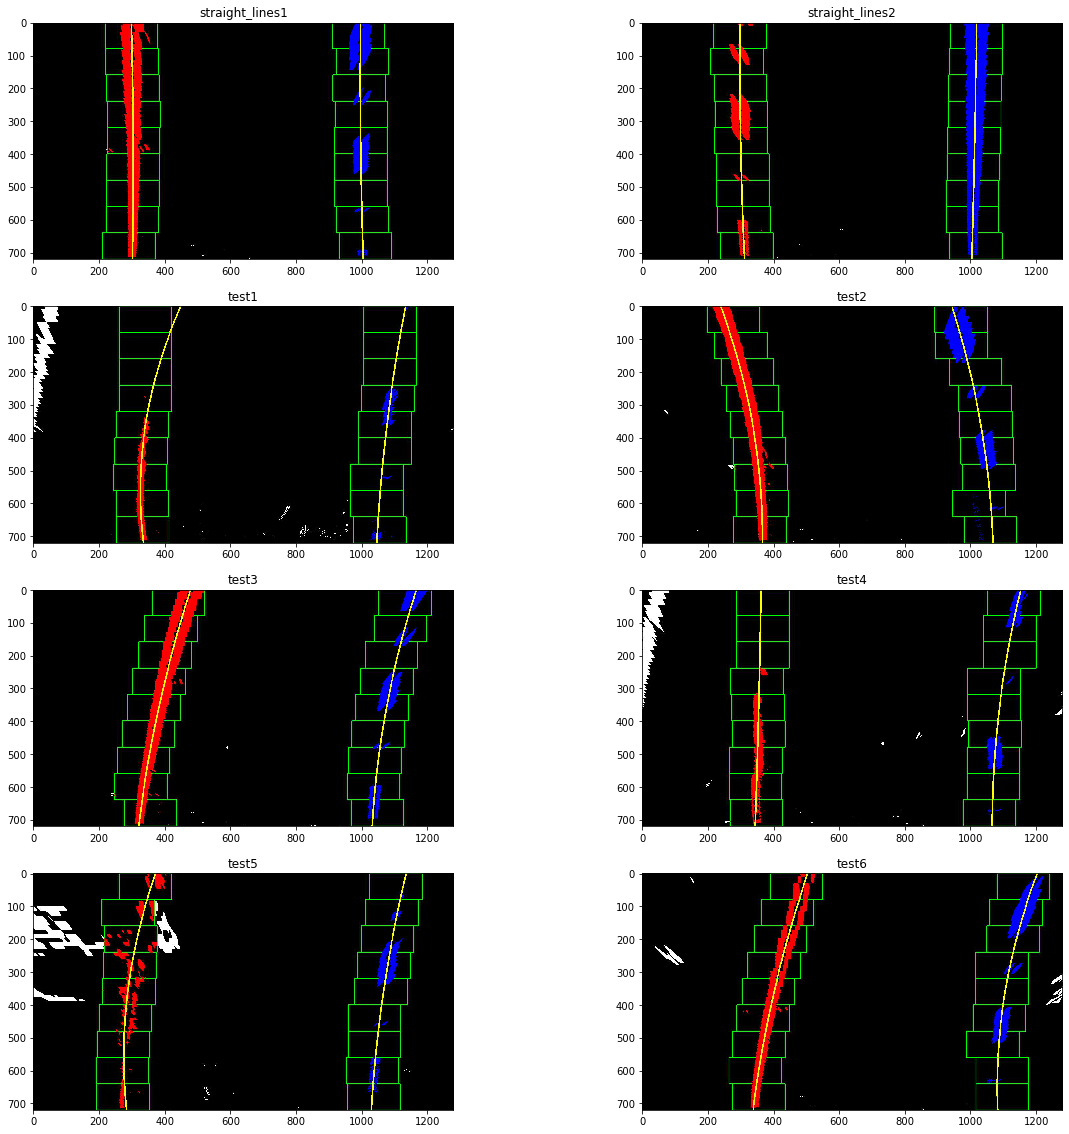

In [11]:
def find_lane_pixels(binary_warped):
    """
    find possible pixels for left lane and right lane
    """
    #print(binary_warped.shape)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80 
    # Set minimum number of pixels found to recenter window
    minpix =50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox >= win_xleft_low) & 
                        (nonzerox < win_xleft_high) &
                        (nonzeroy >= win_y_low) & 
                        (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & 
                        (nonzerox < win_xright_high) &
                        (nonzeroy >= win_y_low) & 
                        (nonzeroy < win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    """
    fit the possible pixels with polynomial curve
    """
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        #print(left_fit, right_fit)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    #out_img[np.int_(ploty), np.int_(left_fitx)] = [255, 255, 0]
    #out_img[np.int_(ploty), np.int_(right_fitx)] = [255, 255, 0]
    # Plots the left and right polynomials on the lane lines
    # plt.plot(right_fitx, ploty, color='yellow')
    # plt.imshow(out_img)
    #print(ploty.shape)
    left_line_pts = np.int_(np.vstack((left_fitx, ploty)).transpose())
    right_line_pts = np.int_(np.vstack((right_fitx, ploty)).transpose())
    cv2.polylines(out_img, ([left_line_pts]), isClosed=False, color=(255,255, 0), thickness=3)
    cv2.polylines(out_img, ([right_line_pts]), isClosed=False, color=(255,255, 0), thickness=3)
    #result = cv2.addWeighted(out_img, 1, window_img, 1, 0)
    return left_fit, right_fit, left_fitx, right_fitx, out_img

# modify last function to just return image
def fit_polynomial_modify(img):
    ret = fit_polynomial(img)
    return ret[-1]

windows_path = "./output_images/windows/"
create_dir(windows_path)
apply([binary_combo, apply_mask, warp, fit_polynomial_modify], 
      undistort_path, windows_path)
showImgs(windows_path)

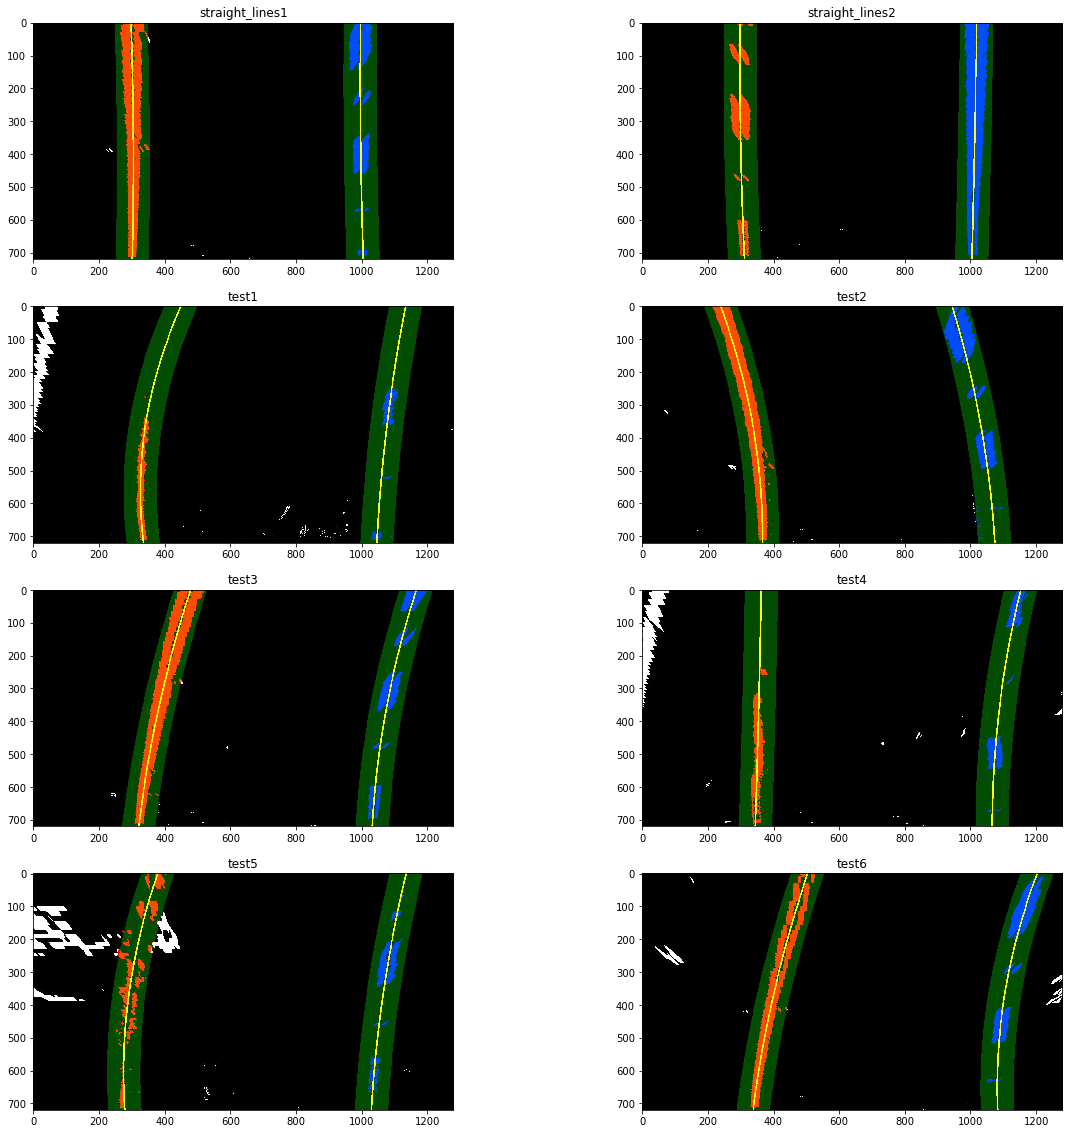

In [12]:
# Polynomial fit values from the previous frame
def fit_poly(img_shape, leftx, lefty, rightx, righty):
 
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit=None, right_fit=None, video_mode=False):
    """
    Search around with given curve, if no curve given, then search by sliding windows
    """
    if video_mode:
        line.left_fit_curr, line.right_fit = left_fit, right_fit
        line.process()
        left_fit, right_fit = line.left_fit_curr, line.right_fit
    
    elif not left_fit:
        left_fit, right_fit, _, _, _ = fit_polynomial(binary_warped)
    #print("left:", left_fit)
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > left_fit[0] * nonzeroy ** 2 + left_fit[1] * nonzeroy + 
                        left_fit[2] - margin) & (nonzerox <= left_fit[0] * nonzeroy ** 2 +
                        left_fit[1] * nonzeroy + left_fit[2] + margin)) 
    right_lane_inds = ((nonzerox > right_fit[0] * nonzeroy ** 2 + right_fit[1] * nonzeroy +
                        right_fit[2] - margin) & (nonzerox <= right_fit[0] * nonzeroy **2 +
                        right_fit[1] * nonzeroy + right_fit[2] + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    left_line_fitted = np.int_(np.vstack((left_fitx, ploty)).transpose())
    right_line_fitted = np.int_(np.vstack((right_fitx, ploty)).transpose())
    cv2.polylines(out_img, [left_line_fitted], False, (255,255, 0), thickness=3)
    cv2.polylines(out_img, [right_line_fitted], False, (255,255, 0), thickness=3)
    
    
    # Plot the polynomial lines onto the image

    cv2.fillPoly(window_img, np.int_([left_line_pts]), color=(0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), color=(0, 255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    ## End visualization steps ##
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty, out_img

def search_around_poly_modify(binary_warped):
    return search_around_poly(binary_warped)[-1]

fitted_path = "./output_images/fitted/"
create_dir(fitted_path)
apply([binary_combo, apply_mask, warp, search_around_poly_modify], 
      undistort_path, fitted_path)
showImgs(fitted_path)  # View your output

### 6. Determine the lane curvature

In [13]:
def measure_curvature_real(fit_cr, y_eval, xm_per_pix=3.7/700, ym_per_pix=30/700):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    ## Implement the calculation of the left line here
    A = fit_cr[0] * xm_per_pix / ym_per_pix ** 2 
    B = fit_cr[1] * xm_per_pix / ym_per_pix
    curverad = (1 + (2 * A * y_eval * ym_per_pix  + B) ** 2) ** (3/2) / np.abs(2 * A)  
    return curverad

In [14]:
def unwarp(warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [15]:
def add_text(img, left_fit, right_fit, left_fitx, right_fitx, ploty, xm_per_pix=3.7/700):
    y_eval = np.max(ploty)
    left_curverad = measure_curvature_real(left_fit, y_eval)
    right_curverad = measure_curvature_real(right_fit, y_eval)
    #curvrad = int(2 / (1 / left_curverad + 1 / right_curverad))  # take average radius
    #curvrad = int(min(left_curverad, right_curverad))
    direction = "right"
    bias = (left_fitx[-1] + right_fitx[-1]) / 2 - (w / 2 - 1)
    if bias < 0:
        bias = - bias
        direction = "left"
    bias *= xm_per_pix
    bias_str = str(bias)[:4]
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
    # fontScale 
    fontScale = 1
    # Blue color in BGR 
    color = (255, 255, 255) 
    # Line thickness of 2 px 
    thickness = 2
    
    cv2.putText(img, "Radius of left Curvature = " + str(int(left_curverad)) + "m", 
                (50, 50), font, fontScale, color, thickness, cv2.LINE_AA) 
    cv2.putText(img, "Radius of right Curvature = " + str(int(right_curverad)) + "m", 
                (50, 100), font, fontScale, color, thickness, cv2.LINE_AA) 
    cv2.putText(img, "Vehicle is " + bias_str + "m " + direction + " of center" , 
                (50, 150), font, fontScale, color, thickness, cv2.LINE_AA) 
    return img

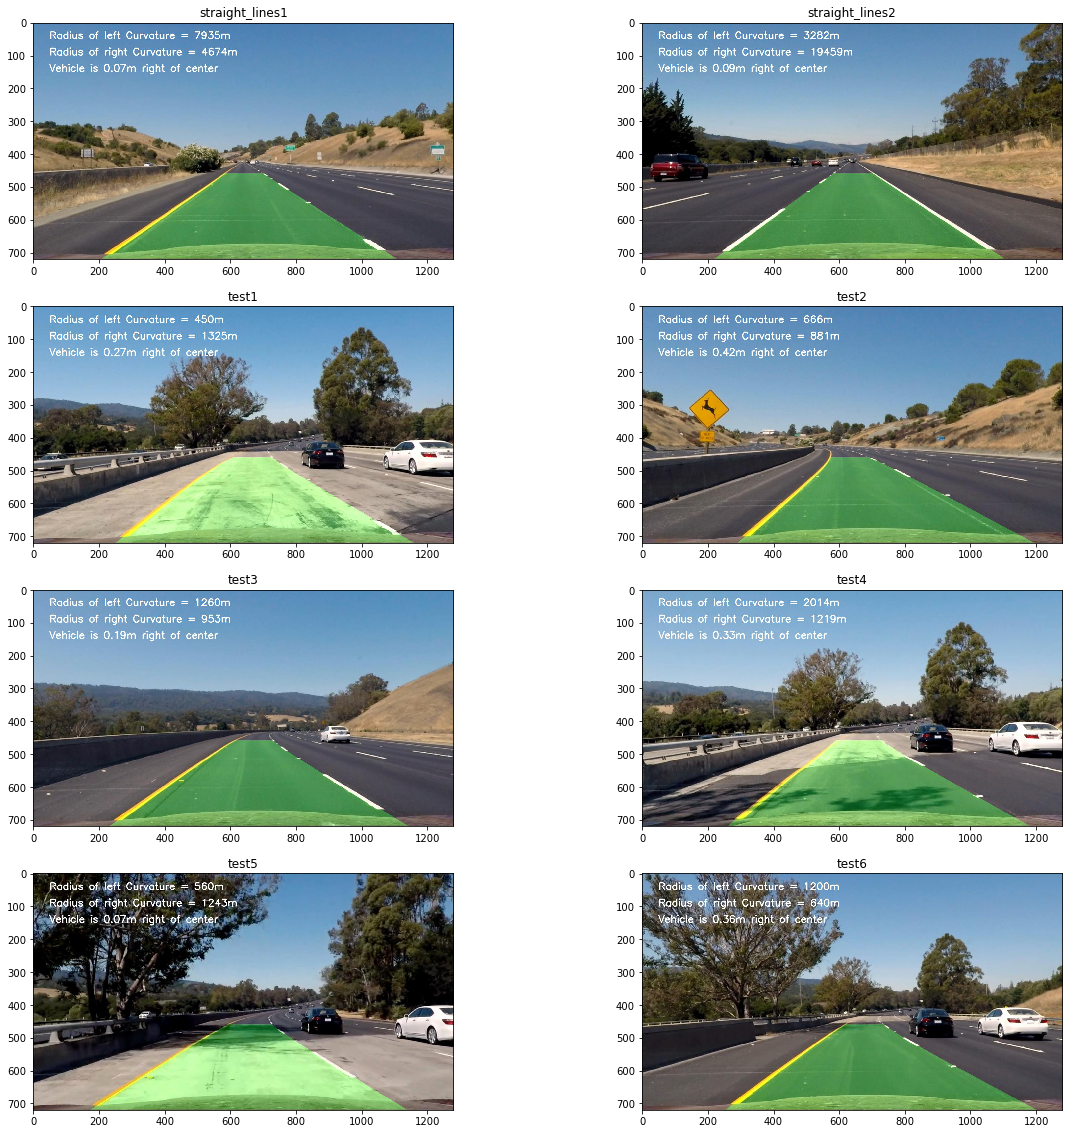

In [16]:
def pipline(img, left_fit=None, right_fit=None):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    binary = binary_combo(undistorted)
    binary_marsked = apply_mask(binary)
    binary_warped = warp(binary_marsked)
    color_warped = warp(undistorted)
    left_fit, right_fit, left_fitx, right_fitx, ploty, fitted = search_around_poly(
                binary_warped, left_fit=None, right_fit=None)
    unwarped =  unwarp(binary_warped, undistorted, left_fitx, right_fitx, ploty)
    result = add_text(unwarped, left_fit, right_fit, left_fitx, right_fitx, ploty)
    return result

final_path = "./output_images/final/"
create_dir(final_path)
apply([pipline], test_imgs_path, final_path)
showImgs(final_path)

### 7. Process video

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
from collections import deque
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.N = 5
        # self.undetected_count = 0
        # self.detected = False  
        self.left_fit_pre = None
        self.right_fit_pre = None
        self.left_fit_curr = None
        self.right_fit_curr = None
        # x values of the last n fits of the line
        self.recent_left_fit = deque(maxlen=self.N)
        self.recent_right_fit = deque(maxlen=self.N)
        
    def process(self):
        self.recent_left_fit.append(self.left_fit)
        self.recent_right_fit.append(self.right_fit)
        self.left_fit_curr = np.mean(self.recent_left_fit, axis=0)
        self.right_fit_curr = np.mean(self.recent_right_fit, axis=0)
        self.left_fit_pre = self.left_fit_curr
        self.right_fit_pre = self.right_fit_curr
        

In [19]:
def process_image(image):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    binary = binary_combo(undistorted)
    binary_marsked = apply_mask(binary)
    binary_warped = warp(binary_marsked)
    color_warped = warp(undistorted)
    left_fit = line.left_fit_pre
    right_fit = line.right_fit_pre
    left_fit, right_fit, left_fitx, right_fitx, ploty, fitted = search_around_poly(
                binary_warped, left_fit=left_fit, right_fit=right_fit, video_mode=True)
    unwarped =  unwarp(binary_warped, undistorted, left_fitx, right_fitx, ploty)
    result = add_text(unwarped, left_fit, right_fit, left_fitx, right_fitx, ploty)
    
    return result

In [20]:
left_line = Line()
project_video_output = './project_output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('./project_video.mp4')

project_clip = clip2.fl_image(pipline)
%time project_clip.write_videofile(project_video_output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./project_output_video.mp4.
Moviepy - Writing video ./project_output_video.mp4



Moviepy - Done !
Moviepy - video ready ./project_output_video.mp4
Wall time: 18min 23s


In [21]:
HTML("""
<video width="720" height="480" controls>
  <source src="{0}">
</video>
""".format(project_video_output))